<a href="https://colab.research.google.com/github/edenlightning/notebooks/blob/notebook/ODSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

# From PyTorch to PyTorch Lightning


In this exercise we will convert an PyTorch MNIST classifier to Lightning, to enjoy all the Lightning features such as built in support for multiple GPUs and nodes, TPUs, logging and vizualization, automatic checkpointing, 16 bit precision, and many more!

You can find more details in [the docs](https://pytorch-lightning.readthedocs.io/en/stable/).


## The PyTorch Model

This is the complete PyTorch model we will be using in this example if some of these concepts such as tensors,transforms, optimizers, etc are new to you check out the [PyTorch Learn the Basics Course](https://pytorch.org/tutorials/beginner/basics/intro.html):

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import os
from torchvision import datasets, transforms

from torch.nn import functional as F

class ImageClassifier(nn.Module):

  def __init__(self):
    super().__init__()
    # mnist images are (3, 32, 32) (channels, width, height) 
    self.layer_1 = torch.nn.Linear(3 * 32 * 32, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    # (b, 1, 28, 28) -> (b, 3*32*32)
    x = x.view(batch_size, -1)

    # layer 1
    x = self.layer_1(x)
    x = torch.relu(x)

    # layer 2
    x = self.layer_2(x)
    x = torch.relu(x)

    # layer 3
    x = self.layer_3(x)

    # probability distribution over labels
    x = torch.log_softmax(x, dim=1)

    return x

# ----------------
# TRANSFORMS
# ----------------
# prepare transforms standard to cifar10
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])


# ----------------
# TRAINING, VAL DATA
# ----------------
cifar_train = CIFAR10(os.getcwd(), train=True, download=True, transform=transform)

cifar_train, cifar_val = random_split(cifar_train, [len(cifar_train) - 5000, 5000])


# ----------------
# TEST DATA
# ----------------
cifar_test = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# ----------------
# DATALOADERS
# ----------------
# The dataloaders handle shuffling, batching, etc...
cifar_train = DataLoader(cifar_train, batch_size=6, )
cifar_val = DataLoader(cifar_val, batch_size=64)
cifar_test = DataLoader(cifar_test, batch_size=64)

# ----------------
# OPTIMIZER
# ----------------
pytorch_model = ImageClassifier()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=1e-3)

# ----------------
# TRAINING LOOP
# ----------------
num_epochs = 1
for epoch in range(num_epochs):

  # TRAINING LOOP
  for train_batch in cifar_train:

    x, y = train_batch

    logits = pytorch_model(x)
    loss = F.nll_loss(logits, y)
    print('train loss: ', loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  # VALIDATION LOOP
  with torch.no_grad():
    val_loss = []
    for val_batch in cifar_val:
      x, y = val_batch
      logits = pytorch_model(x)
      val_loss.append(F.nll_loss(logits, y).item())

    val_loss = torch.mean(torch.tensor(val_loss))
    print('val_loss: ', val_loss.item())

---
## Setting up the Problem
In a research project, we normally care about the following components:

- the model
- the data
- the loss
- the optimizer


## Part 1: Convert the Model to a LightningModule

### Step 1: Copy the model and forward method


In this exercise we will be using a 3-layer fully-connected neural network that takes as input an image that is 3x28x28 and outputs a probability distribution over 10 possible labels.

First, let's look at the model definition in PyTorch

```
class MNISTClassifier(nn.Module):

  def __init__(self):
    super().__init__()
    # mnist images are (1, 28, 28) (channels, width, height) 
    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    # (b, 1, 28, 28) -> (b, 1*28*28)
    x = x.view(batch_size, -1)

    # layer 1
    x = self.layer_1(x)
    x = torch.relu(x)

    # layer 2
    x = self.layer_2(x)
    x = torch.relu(x)

    # layer 3
    x = self.layer_3(x)

    # probability distribution over labels
    x = torch.log_softmax(x, dim=1)

    return x
   
```

This model defines the computational graph to take as input an MNIST image and convert it to a probability distribution over 10 classes for digits 0-9.

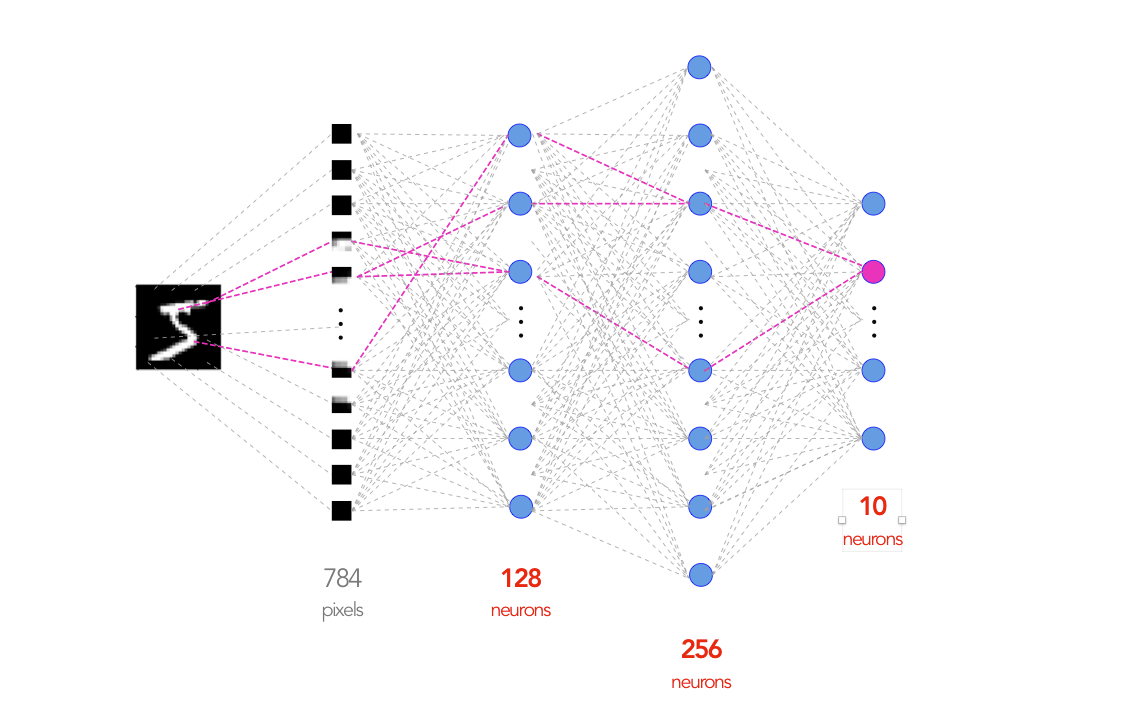



To convert this model to PyTorch Lightning we preform the following simple steps:

### Step 1: Import Lightning 
```python
import pytorch_lightning as pl
```

```python
class ImageClassifier(pl.LightningModule): # PyTorch
```

2. replace the `nn.Module` with the [`pl.LightningModule`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html)

    from 

    ```python
    class ImageClassifier(nn.Module): # PyTorch
    ```
    to 
    ```python
    class LitMNISTMNISTClassifier(pl.LightningModule): # Pytorch Lightning
    ```

### Step 2: Convert the Optimizer

Now we choose how we're going to do the optimization. We'll use [Adam](https://pytorch.org/docs/stable/optim.html) instead of SGD because it is a good default in most DL research.

In PyTorch, the optimizer is given the weights when we init the optimizer:



```
pytorch_model = MNISTClassifier()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=1e-3)
```
The optimizer code is the same for Lightning, except that it is added to the function [`configure_optimizers()`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html?highlight=configure_optimizers#configure-optimizers) in the LightningModule.


### Step 3: Convert the Training Loop

We now have defined the model key ingredients:
- A model (3 layer network)
- An optimizer (Adam)

The next thing we are going to add to our LightningModule is the training loop logic. The PyTorch training routine does the following:

1. Iterates for many epochs (an epoch is a full pass through all of our data... ie: we want to see the data multiple times).
$$D = \{ (x_1, y_1), ..., (x_n, y_n) \}$$
2. In each epoch we iterate the dataset by batches.
$$ b \in D $$
3. We perform a forward pass
$$\hat{y} = f(x) $$
4. We compute a loss
$$ L = - \sum_{i}^{C}{y_i \log(\hat{y}_i)} $$
5. Perform a backward pass to compute the gradients for all our weights.
$$\nabla w_i = \frac{\partial L}{\partial w_i} \quad \quad \forall \quad w_i$$
6. We apply those the gradients to each weight
$$w_i = w_i + \alpha \nabla w_i$$


```python

num_epochs = 100
for epoch in range(num_epochs):            # (1)
  for batch in dataloader:                 # (2)
    x, y = batch

    logits = model(x)                      # (3)
    loss = loss = F.nll_loss(logits, y)    # (4)

    loss.backward()                        # (5)
    optimizer.step()                       # (6)

    
```


In Lightning, we put the training logic into different LightningModule hooks. In this case, we will put the core training logic in the [`training_step`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#training-step) hook, performs what happens inside the "training loop" (steps 3-6): it takes a batch of tensors as input, and returns the calculated loss.

1. Define a `training_step` method that includes a `batch` and a `batch_idx` parameters.
2. In your `training_step`, split the input `batch` to an `x` and a `y`.
3. Compute the logits by calling `self.forward`.
4. Compute the loss on your logits and labels.
5. Log your training loss using the Lightning built in logger [`self.log`](https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html#automatic-logging) method.

```
    self.log('training_loss', loss)
```
6. Return the calculated loss






### Step 4: Convert the Validation Loop

We already moved the training core logic to `training_step`. Let's take a look at the PyTorch validation routine.

```python
for epoch in range(num_epochs):                             # (1)

  # TRAINING LOOP

  # VALIDATION LOOP
  with torch.no_grad():
    val_loss = []
    for val_batch in mnist_val:                             # (2)
      x, y = val_batch
      logits = pytorch_model(x)                             # (3)
      val_loss.append(F.nll_loss(logits, y).item())         # (4)

    val_loss = torch.mean(torch.tensor(val_loss))           # (5)
    print('val_loss: ', val_loss.item())
```

The validation routine does the following:

1. Iterates for many epochs.
2. For each epoch, iterate on batched of the validation set. 
3. Preform a forward pass.
4. Computed the loss.
5. Caculates and print the mean loss per epoch.

Similar to `training_step`, LightningModule has a `validation_step` hook to preformhat happens inside the validation loop. It recieves as input your data batch and index, and preform any necessary calculation and logging.

However, notice that we still want to compute the average loss which accounts for all the batches in the validation loop. Now you might be wondering, how can we calculate the mean loss per epoch, if the `validation_step` only includes a single batch?

LightningModule has hooks for every point of the training, validation and tets routine. If we want to add custom functionality to happen, for example, on the end of each validation epoch, we will use the `validation_epoch_end` hook, which receives a list (outputs) with the output of the ```validation_step``` for each batch:

```python

outputs = []
for batch in validation_dataloader:
   loss = some_loss(batch)   # validation_step
   outputs.append(loss       # validation_step

outputs = outputs.mean()     # validation_epoch_end
```




To add validation logic to your LightningModule:

1. define a `validation_step` method that includes a `batch` and a `batch_idx` parameters.
2. In your `validation_step`, split the input `batch` to an `x` and a `y`.
3. Compute the logits by calling `self.forward`.
4. Compute the loss on your logits and labels.
5. Log your training loss using the Lightning built in logger [`self.log`](https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html#automatic-logging) method.

```
    self.log('val_loss', loss)
```

No need to return the loss in this case.

Now it's your turn

### LAB Excerise: Refactor the PyTorch code into a LightningModule using the 4 steps above:



In [ ]:
import pytorch_lightning as pl

# PART 1: Add here your LightningMNISTClassifier
class LightningMNISTClassifier(pl.LightningModule):
 
  # STEP 1: add __init__ and forward from the PyTorch model
  def __init__(self):
 
  def forward(self, x):

  # STEP 2: return your optimizer here.
  # Tip: your paramteres are now part of the model, and can be accessed using self.parameters.
  def configure_optimizers(self):

  # STEP 3: add training logic here
  def training_step(self, batch, batch_idx):
    # 1. split the batch to separate the labels
    # 2. preform the forward pass
    # 3. compute the loss
    # 4. log the loss using self.log method
    # 5. return the loss

  # STEP 4: add validation logic here
  def validation_step(self, batch, batch_idx):
    # 1. split the batch to separate the labels
    # 2. preform the forward pass
    # 3. compute the loss
    # 4. log the loss using self.log method (make sure to use a different name than the one you used for training loss)

Notice a few things about this structure:

1. It is highly organized.
2. It is the SAME PyTorch code, except it's been organized.
3. The inner loop of the PyTorch training code became the ```training_step```. But we didn't have to do any of the gradient stuff because Lightning will do it automatically!
```python
  for train_batch in mnist_train:
    x, y = train_batch                       # training_step
 
    logits = pytorch_model(x)                # training_step
    loss = cross_entropy_loss(logits, y)     # training_step
    print('train loss: ', loss.item())       # training_step
 
    loss.backward()
 
    optimizer.step()
    optimizer.zero_grad()
```
4. The inner loop of the PyTorch validation code became the ```validation_step```.

```python
outputs = []
for batch in validation_dataloader:
   loss = some_loss(batch)   # validation_step
   outputs.append(loss       # validation_step

```
5. And the ```validation_end``` step allows us to calculate metrics for the full validation set. Again, we didn't have to turn of gradients or freeze the model or loop anything. Lightning will do this for us.

```python
outputs = outputs.mean()     # validation end
validation_loss = outputs
```



The code for lightning is EXACTLY the same!

This means you can use a LightningModule exactly as you would a PyTorch module:



```
# restore with PyTorch
pytorch_model = MNISTClassifier()
pytorch_model.load_state_dict(torch.load(PATH))
model.eval()


lightning_model = LitMNISTMNISTClassifier.load_from_checkpoint(PATH)
lightning_model.eval()
```



## Part 2: Manage Data with LightningDataModules

### Instructions

In our PyTorch example we have three splits of the MNIST dataset of handwritten digits: a training, validation and test split.
This again, is the same code in PyTorch as it is in Lightning.

The dataset is added to the Dataloader which handles the loading, shuffling and batching of the dataset.

In short, data preparation has 3 steps:

1. Image transforms (these are highly subjective).
2. Generate training, validation and test dataset splits.
3. Wrap each dataset split in a DataLoader

Here's the PyTorch version:

```
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms


# ----------------
# TRANSFORMS
# ----------------
# prepare transforms standard to MNIST
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])

# ----------------
# TRAINING, VAL DATA
# ----------------
mnist_train = MNIST(os.getcwd(), train=True, download=True)

# train (55,000 images), val split (5,000 images)
mnist_train, mnist_val = random_split(mnist_train, [55000, 5000])

# ----------------
# TEST DATA
# ----------------
mnist_test = MNIST(os.getcwd(), train=False, download=True)

# ----------------
# DATALOADERS
# ----------------
# The dataloaders handle shuffling, batching, etc...
mnist_train = DataLoader(mnist_train, batch_size=64)
mnist_val = DataLoader(mnist_val, batch_size=64)
mnist_test = DataLoader(mnist_test, batch_size=64)
```



In PyTorch, this dataloading can be done anywhere in your main training file... In PyTorch Lightning dataloaders can be used directly or three methods can be grouped together under a LightningDataModule.

- train_dataloader()
- val_dataloader()
- test_dataloader()

And a fourth method meant for data preparation/downloading.
- prepare_data()

Lightning takes this approach so that every model implemented with Lightning follows the SAME structure. This makes code extremely readable and organized.

This means that when you run into a Github project that uses Lightning you'll be able to know exactly where the data processing/loading happened.

Now it's your turn to try 

### LAB Excerise: Refactor the PyTorch data managment code into a Create your LghtningDataModule using the section 2 instructions above:


To create your LightningDataModule copy the relevant lines from the PyTorch dataloading code.

1. Create your LightningDataModule
2. add a `setup` method, that gets a `stage` input and does any operation you need to do on your data (this will be called on every GPU, if you want your operation to be done only once use `prepare_data`):
* perform train/val/test splits
* apply transforms (defined explicitly in your datamodule or assigned in init)
etc…
3. Define a `train_dataloader` method, that return the train dataloader.
4. Define a `val_dataloader` method, that return the validation dataloader.
5. Define a `test_dataloader` method, that return the test dataloader.




In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

# STEP 1: Create a pl.LightningDataModule
class MNISTDataModule(pl.LightningDataModule):

  # STEP 2: add a setup method
  def setup(self, stage):
    # TODO: add your images transforms here

    # download and split the datasets.
    # It is recommended use save your datasets as class variables and use them 
    # in the dataloader methods:
    # self.mnist_train = .....
    # self.mnist_val = ...
    # self.mnist_test = ....



  # STEP 3: add a train_dataloader method, returning the train dataloader
  def train_dataloader(self):

  # STEP 4: add a val_dataloader method, returning the validation dataloader
  def val_dataloader(self):

  # STEP 5: add a test_dataloader method, returning the test dataloader
  def test_dataloader(self):


## Let the training begin

That's it!

We created out LightingModule, that includes the model architucture, forward pass, optimizer, the training and validation logic.

We created a LightningDataModule that contains all our data related code. Now all that is left is to initilize the Lightning [`Trainer`](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html), which automates all the other stuff we don't need from the PyTorch code - which we have to duplicate in EVERY SINGLE project we start which makes it boilerplate code.



In [ ]:
# train
model = LightningMNISTClassifier()
data = MNISTDataModule()
trainer = pl.Trainer()

trainer.fit(model, data)

## Additional PyTorch Lightning Features

Although those benefits are super nice, the real benefits don't show up until your project gets more complicated.


### Single GPU training
For instance, now assume you want to run this same code on a GPU. To do that in the PyTorch example you'd have to make these changes.

```python
model.gpu(0)

for batch in data:
  batch = batch.gpu(0)
```

But in Lightning you don't have to change your code! Simply add a trainer flag
```python
Trainer(gpus=1)
```

Give it a try! Note that you will need to add GPUs to your runtime (Runtime > Chnage runtime type > choose GPUs).







### 16 bit precision
What about 16-bit precision? In the PyTorch example that would again get very complicated! That's also outside of the scope of this tutorial.

You would also need to install a library called apex by NVIDIA (applies to both PyTorch and Lightning)

But in lightning you can just set the flag:
```python
Trainer(precision=16)
```



### Logging
Remember that you got tensorboard for free? In Lightning we support more advanced visualization platforms which again are trivial to change
```python
# replace tensorboard
Trainer(logger=CometML(...))

```


### Multiple GPUs
What about multiple GPUs? In The PyTorch example, you would have to use the dataparallel or distributed parallel classes which are also outside the scope of this tutorial.

In Lightning you would do:
```python
Trainer(gpus=8, distributed_backend='ddp')
```

Note: this is not available in Google Colab.


### Finding bottlenecks
What if your code is slow and you want to figure out where the issues are? You can try the [pytorch profiler](https://pytorch.org/docs/stable/bottleneck.html) which can get complicated to interpret and run.

But in lightning you can get basic profiling by doing the following
```python
Trainer(profile=True)
```

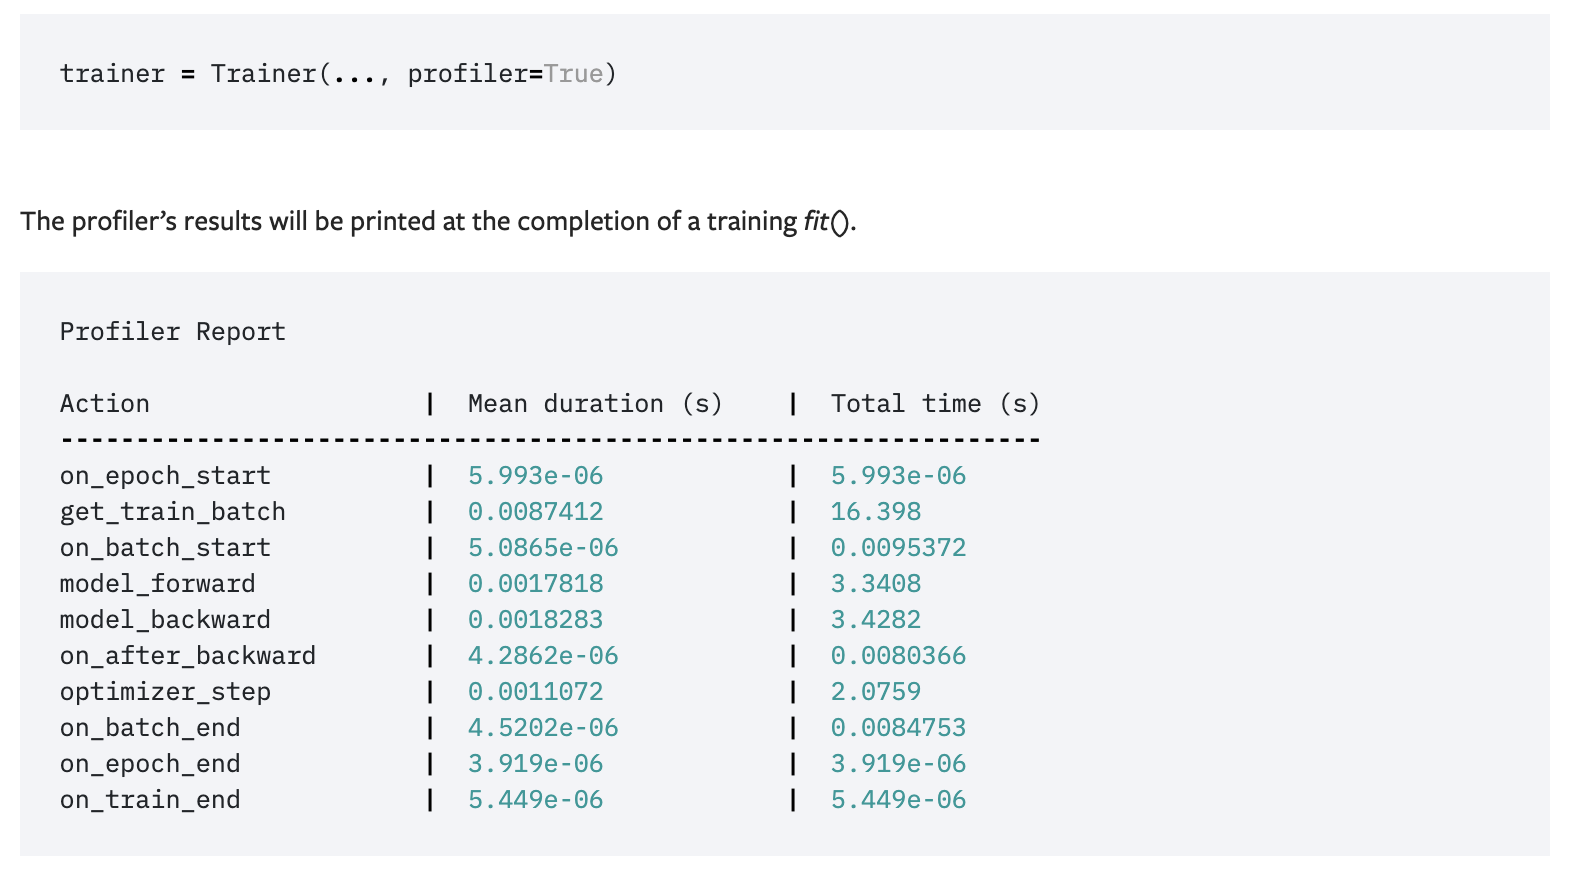


Or more advanced profiling by:
```python
Trainer(profile=AdvancedProfiler(...))
```

### 40+ other features
The point is that with just by simply organizing your PyTorch code into a LightningModule you can get access to features like the ones above and 40+ other features such as:

- Gradient clipping
- Automatic truncated back propagation through time
- HPC cluster auto-resubmission
- Early stopping
- ...
- Built-in debugging tests
- Multi-node training (yup!)


### Complete Lab Solutions (Try not to peak here until you've at least attempted to solve two exercises above)

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os

class LightningMNISTClassifier(pl.LightningModule):

    def __init__(self):
        super(LightningMNISTClassifier, self).__init__()

        # mnist images are (1, 28, 28) (channels, width, height) 
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # layer 1 (b, 1*28*28) -> (b, 128)
        x = self.layer_1(x)
        x = torch.relu(x)

        # layer 2 (b, 128) -> (b, 256)
        x = self.layer_2(x)
        x = torch.relu(x)

        # layer 3 (b, 256) -> (b, 10)
        x = self.layer_3(x)

        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)   # we already defined forward and loss in the lightning module. We'll show the full code next
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

class MNISTDataModule(pl.LightningDataModule):

  def setup(self, stage):
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.1307,), (0.3081,))])
      
    # prepare transforms standard to MNIST
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    
    self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=64)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=64)

  def test_dataloader(self):
    return DataLoader(self,mnist_test, batch_size=64)

# train
model = LightningMNISTClassifier()
data = MNISTDataModule()

trainer = pl.Trainer(max_epochs=3)

trainer.fit(model, data)

---
## Going one step further
Lightning lets you take thins one step further and make the LightningModule more reusable.

In this case, we can actually extract the model definition, which will let us pass in and compare different model backbones for our MNIST Classifier.

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os

class Backbone(nn.Module):

    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height) 
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # layer 1 (b, 1*28*28) -> (b, 128)
        x = self.layer_1(x)
        x = torch.relu(x)

        # layer 2 (b, 128) -> (b, 256)
        x = self.layer_2(x)
        x = torch.relu(x)

        # layer 3 (b, 256) -> (b, 10)
        x = self.layer_3(x)

        return x

class LightningClassifier(pl.LightningModule):

    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone    

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        
        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        # probability distribution over labels
        logits = self.backbone(x)
        x = torch.log_softmax(x, dim=1)
        
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# train
model = Backbone()
classifier = LightningClassifier(model)
data = MNISTDataModule()
trainer = pl.Trainer()

trainer.fit(classifier, data)

You'll also notice we dropped the forward method! 

In Lightning, forward is optional. We use the forward for defining what to do for inference (predictions) (ie: when you call your model like ```model(x)``` and we use the training_step to define the training loop completely.

That's all it takes to train the same model using Lightning!

## PyTorch and Lightning Differences

Let's call out a few differences:

1. Without Lightning, the PyTorch code is allowed to be in arbitrary parts of the file. With Lightning, this is structured. This is why Lightning is more of a template for PyTorch than a framework!
2. In Lightning we didn't have to write any training loops. Instead, we wrote what happens inside the loop

```python
for epoch:
  for batch in data:
    # training_step
    loss.backward()
    optimizer.step()
```

3. We saw the weights summarized

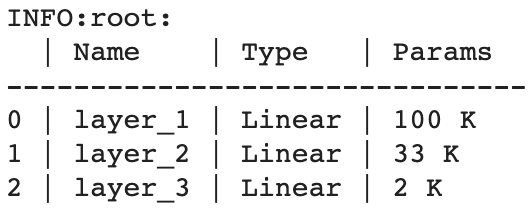

4. We get a free progress bar
5. The validation and training loop were automated
6. We saved weights automatically
7. We get free tensorboard logging

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Reusability and Readability
But the main underlying benefit behind all of this is that with Lightning you've succesfully abstracted out all the code that is hardward specific or related to engineering. This makes your code highly readable and easier to reproduce because it isn't litered with engineering code.

## Rigurous testing
Another benefit of lightning is that it is rigurously tested daily. This means that if Lightning handles 90% of your code, it means that part is very well tested to ensure it is correct. It limits the footprint of bugs to the 10% you have to write.

For professors and research leads it means you spend less time debugging your student's code :)



## Bonus excerise: TPU example
To illustrate, let's train the same lightningmodule without ANY code changes using TPUs.

First, we need to change the colab Runtime to use TPUs.


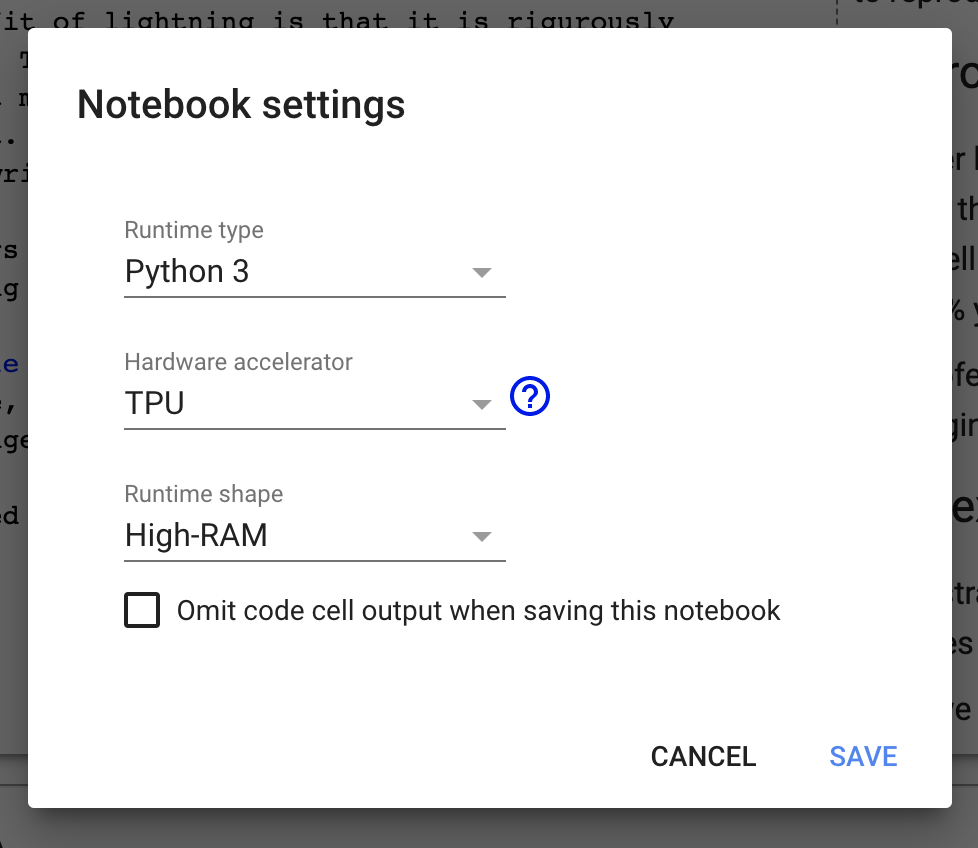

Next we need to install xla. XLA is a library written by the PyTorch team at Facebook and the TPU team at Google.

XLA compiles your PyTorch code onto a static graph and sends it into the TPU.

---
### Install XLA
First, we have to install the XLA library to support TPUs on PyTorch

###  Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [ ]:
! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

In [ ]:
import collections
from datetime import datetime, timedelta
import os
import requests
import threading

_VersionConfig = collections.namedtuple('_VersionConfig', 'wheels,server')
VERSION = "torch_xla==nightly"  #@param ["xrt==1.15.0", "torch_xla==nightly"]
CONFIG = {
    'xrt==1.15.0': _VersionConfig('1.15', '1.15.0'),
    'torch_xla==nightly': _VersionConfig('nightly', 'XRT-dev{}'.format(
        (datetime.today() - timedelta(1)).strftime('%Y%m%d'))),
}[VERSION]
DIST_BUCKET = 'gs://tpu-pytorch/wheels'
TORCH_WHEEL = 'torch-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
TORCH_XLA_WHEEL = 'torch_xla-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
TORCHVISION_WHEEL = 'torchvision-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)

# Update TPU XRT version
def update_server_xrt():
  print('Updating server-side XRT to {} ...'.format(CONFIG.server))
  url = 'http://{TPU_ADDRESS}:8475/requestversion/{XRT_VERSION}'.format(
      TPU_ADDRESS=os.environ['COLAB_TPU_ADDR'].split(':')[0],
      XRT_VERSION=CONFIG.server,
  )
  print('Done updating server-side XRT: {}'.format(requests.post(url)))

update = threading.Thread(target=update_server_xrt)
update.start()

# Install Colab TPU compat PyTorch/TPU wheels and dependencies
!pip uninstall -y torch torchvision
!gsutil cp "$DIST_BUCKET/$TORCH_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCH_XLA_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCHVISION_WHEEL" .
!pip install "$TORCH_WHEEL"
!pip install "$TORCH_XLA_WHEEL"
!pip install "$TORCHVISION_WHEEL"
!sudo apt-get install libomp5
update.join()

### Re-install Lightning
Next we need to reinstall lightning because we switched to the TPU runtime.

Make sure you click restart runtime when it completes!

In [ ]:
! pip install git+git://github.com/PyTorchLightning/pytorch-lightning.git@master --upgrade

### Re-import LightningModule
We changed the runtime, so let's re-import the lightning code (NO CHANGES THOUGH)

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os

class LightningMNISTClassifier(pl.LightningModule):
  # TODO: paste your code here


### Train

In [ ]:
model = LightningMNISTClassifier()
data = MNISTDataModule()

trainer = pl.Trainer(num_tpu_cores=8)
trainer.fit(model, data) 

## Extensibility
PyTorch Lightning was designed for professional researchers and research scientists. As such, it was made to be as flexible as needed to account for all research use cases.

Extensibility in lightning comes in two flavors:

1. Method overriding
2. Callbacks

### Hook overriding
In Lightning you can override ANY part of training. A non-exhaustive list includes:
- forward pass
- backward pass
- applying optimizers
- setting up distributed training
- setting up 16 bit
- how we do truncated back prop
- ...
- anything you would need to configure



#### 16-bit  precision
Imagine you wanted to implement your own way of doing 16-bit precission. In Lightning you would just override this function ([docs](https://pytorch-lightning.readthedocs.io/en/latest/lightning-module.html#pytorch_lightning.core.LightningModule.configure_apex)):

```python
# Default implementation used by Trainer.
def configure_apex(self, amp, model, optimizers, amp_level):
    model, optimizers = amp.initialize(
        model, optimizers, opt_level=amp_level,
    )

    return model, optimizers
```

The override would happen in the LightningModule:
```python
class LightningMNISTClassifier(pl.LightningModule):

  def configure_apex(self, amp, model, optimizers, amp_level):
    # do your own thing
```


You can pretty much override ANY part of training. Here's a non-exhaustive list:

#### Optimizer step ([docs](https://pytorch-lightning.readthedocs.io/en/latest/lightning-module.html#pytorch_lightning.core.LightningModule.optimizer_step))

```python
def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    optimizer.step()
    optimizer.zero_grad()
```



#### Backward pass ([docs](https://pytorch-lightning.readthedocs.io/en/latest/pytorch_lightning.core.hooks.html#pytorch_lightning.core.hooks.ModelHooks.backward))

```python
def backward(self, use_amp, loss, optimizer):
    if use_amp:
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
    else:
        loss.backward()
```

#### Distributed configuration ([docs](https://pytorch-lightning.readthedocs.io/en/latest/lightning-module.html#pytorch_lightning.core.LightningModule.configure_ddp))
```python
def configure_ddp(self, model, device_ids):
    # Lightning DDP simply routes to test_step, val_step, etc...
    model = LightningDistributedDataParallel(
        model,
        device_ids=device_ids,
        find_unused_parameters=True
    )
    return model
```

### Callbacks ([docs](https://pytorch-lightning.readthedocs.io/en/latest/callbacks.html))
Lightning has a callback system that lets you write arbitrary functionality for different parts of training.

The beauty is that this funcionality separates non-essential code from the research logic

In [ ]:
import pytorch_lightning as pl

class MyPrintingCallback(pl.Callback):

    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('trainer is init now')

    def on_train_end(self, trainer, pl_module):
        print('do something when training ends')

In [ ]:
model = LightningMNISTClassifier()
data = MNISTDataModule()

trainer = pl.Trainer(num_tpu_cores=8)
trainer = pl.Trainer(num_tpu_cores=8, callbacks=[MyPrintingCallback()])
trainer.fit(model, data) 

## Summary
In this tutorial we accomplished the following:

1. Showed how PyTorch Lightning is simply a refactoring of PyTorch code.
2. Showed a few key benefits of using Lightning instead
3. Showed how flexible Lightning is because it's targeted at Researchers.


[Convert your code to PyTorch Lightning today!](https://github.com/PyTorchLightning/pytorch-lightning)

## Next Steps if You Have Extra Time

Congragulations for getting to the end of the PyTorch Lightning Lab if you have extra time feel free to try one of the following Challenges.

1. Join our [PyTorch Lightning Slack Community](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-f6bl2l0l-JYMK3tbAgAmGRrlNr00f1A) for fresh perspectives and support we are active their every day. 
2. Explore PyTorch [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/?badge=latest) and Train a Classifer on Your own Task 
3. Check out the Self Supervised and Reinforcment Learning Examples in [PyTorch Lightning Bolts](https://lightning-bolts.readthedocs.io/en/latest/)
4. See how you can get involved by reading our [Contributor Guide](https://pytorch-lightning.readthedocs.io/en/stable/generated/CONTRIBUTING.html) and checking out the [list of good first issues](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)! We pride ourselves on community and would love for you to get involved. 